In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import binom, poisson
import time
from math import pi,sqrt
from scipy.signal import convolve


<img src="https://tva1.sinaimg.cn/large/007S8ZIlly1gi42jrjhrrj31340ak7fs.jpg"  />

# Synthesis

<img src="https://tva1.sinaimg.cn/large/007S8ZIlly1gi41shdszrj30m80gg46i.jpg" style="zoom:30%;" />

* **Chip synthesis**: synthesized in parallel in different spatial locations on a chip
* **phoshoramidite chemistry**: bases are added to current sequence serially in a 3 stages (deprotection, coupling, oxidation) synthesis loop. To add specific base to specific location at least one step of the synthesis loop must be controlled spatially. 
    * Controlling the **deprotection step** with light or electric **activation** (Custom Array)
    * Controlling the **coupling step** by **printing** desired nucleosides to appropriate feature locations (Agilent, Twist Bioscience) 


## Error within sequences
* In the synthesis process, nucleosides insertion, deletion and substitution might occur due to improper activation or nucleoside printing.
* Typical error rate: 1:200-1:2000


## Coupling efficiency --> Yield
*  the synthesis process might be terminated at each step because of unsuccessful coupling, and there is a parameter called coupling efficiency describing the possibility of successfully adding one nucleoside to current strand, typically around 98%-99.5%
* this limited the length of synthesized sequence as the possibility of getting complete sequence will decrease exponentially with the increase of sequence length. 

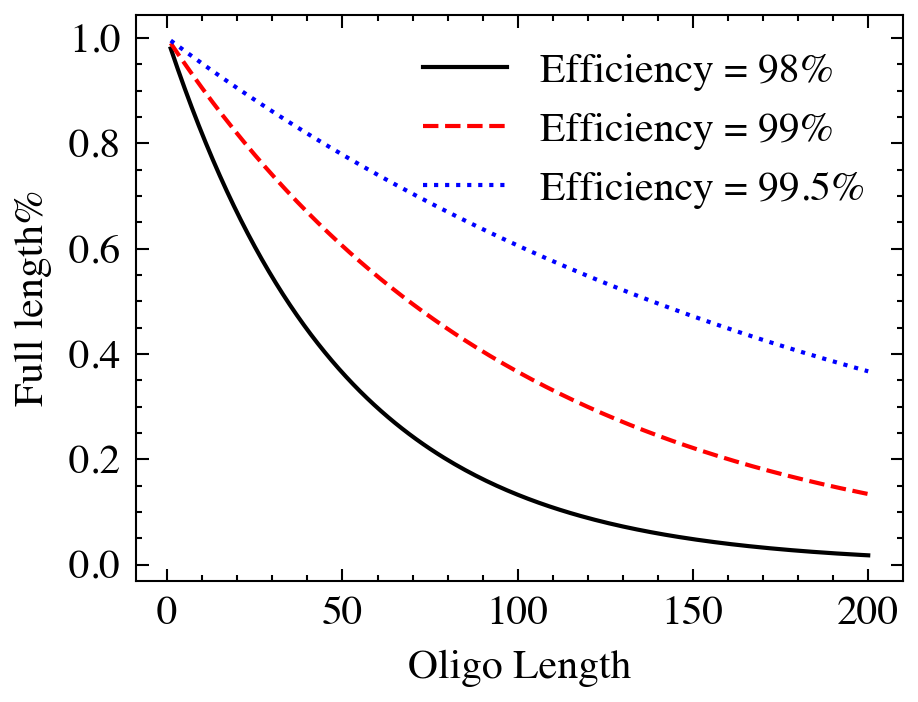

In [19]:
Coupling_eff = [98,99,99.5]
L = np.linspace(1,200,200)
fig = plt.figure(dpi=300)
for C in Coupling_eff:
    Percentage = (C/100) ** L
    label = 'Efficiency = ' + str(C) + '%'
    plt.plot(L,Percentage,label = label)

fontSize = 10
plt.xticks(fontsize=fontSize)
plt.yticks(fontsize=fontSize)
    
plt.legend(fontsize=fontSize)
plt.xlabel('Oligo Length', fontsize=fontSize)
plt.ylabel('Full length%', fontsize=fontSize)


plt.show()



## Yield --> Uneven distribution of oligos

* The number distribution of successfully synthesized oligos will also become uneven due to this stochastic process, which can be theoretically modeled as a binomial distribution
* In which p = coupling_efficiency ** L

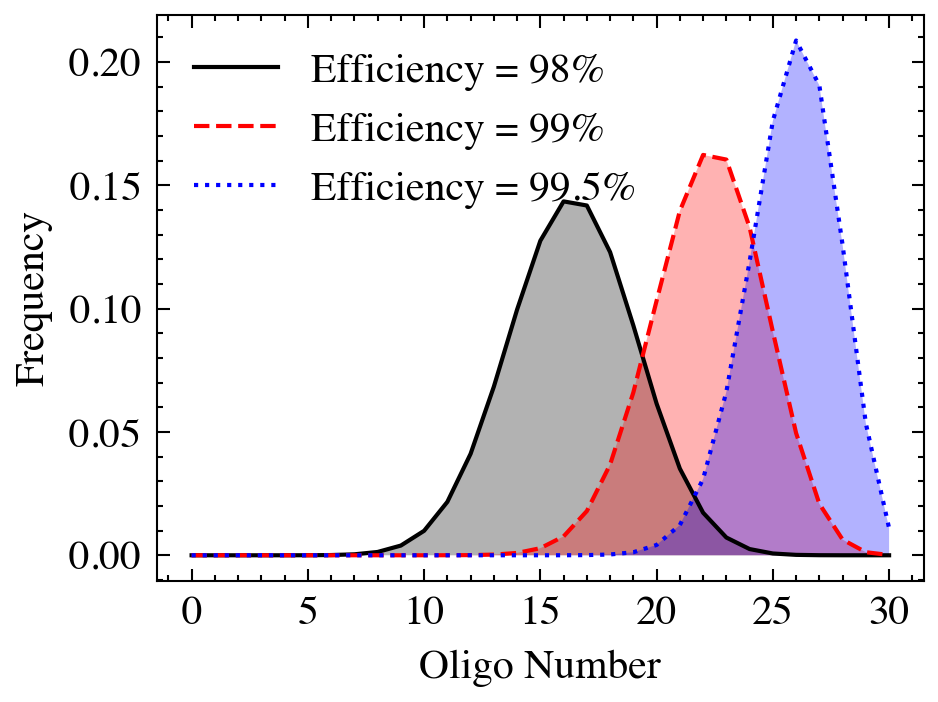

In [20]:
n = 30
L = 120
X = np.linspace(0,n,n+1)

fig = plt.figure(dpi=300)
for C in Coupling_eff:
    FY = (C/100) ** n
    label = 'Efficiency = ' + str(C) + '%'
    Probs_binom = binom.pmf(X,n,FY)
    Probs_poisson = poisson.pmf(X,n*FY)
    plt.plot(X,Probs_binom,label = label)
    plt.fill_between(X,0,Probs_binom,alpha = 0.3)

plt.xticks(fontsize=fontSize)
plt.yticks(fontsize=fontSize)
    
plt.legend(fontsize=fontSize)
plt.xlabel('Oligo Number', fontsize=fontSize)
plt.ylabel('Frequency', fontsize=fontSize)


fig.savefig('distribution.png', dpi=300)    

# Decay

<img src="https://tva1.sinaimg.cn/large/007S8ZIlly1gi42bp6aa1j30pa0digqf.jpg" style="zoom:30%;" />

* Synthesized DNA strands will decay in storage process. There are two processes related to decay: depurination and 
deamination. 
    * **Depurination** generates AP sites which undergoes spontaneous cleavage, leading to strand break and thus sequence lost; 
    * **Deamination** causes C2U mutation, which then leads to G2T mutation when using proof-reading enzymes, or sequence lost using proof reading enzymes

# PCR

### Branching process:
<img src="https://tva1.sinaimg.cn/large/007S8ZIlly1gi41y6im28j30ku0dkn18.jpg" style="zoom:30%;" />

### Distribution under M = 1, calculated with the recurrence expression:
<img src="https://tva1.sinaimg.cn/large/007S8ZIlgy1geeeywagcwj30sw06sq3j.jpg" style="zoom:30%;" />


In [5]:
amp_ratio = 0.8
M = 1
Rounds = 15

P = np.zeros(M+1)
P[M] = 1

Ps = [P]
t_prev = time.time()
for j in range(Rounds):
    P_next = np.zeros(P.size*2-1)
    for i,p in enumerate(P):
        X = np.arange(0,i+1)
        pmf = binom.pmf(X,i,amp_ratio)
        P_next[i:i*2+1] += pmf * p
    P = P_next
    Ps.append(P)
    if j > 10:
        t_cur = time.time(); print(f'iter {j} done. spent {round(t_cur-t_prev,4)}s'); t_cur = t_prev

iter 11 done. spent 0.7083s
iter 12 done. spent 1.8603s
iter 13 done. spent 5.3883s
iter 14 done. spent 17.5261s


### Distribution under M > 1, calculated with that under M = 1 with convolution:
* `pmf = convolve(pmf,pmf)`

### Guassian Approximation with u and sigma:

<img src="https://tva1.sinaimg.cn/large/007S8ZIlgy1geegd0c59aj30xc06mwf9.jpg" style="zoom:30%;" />

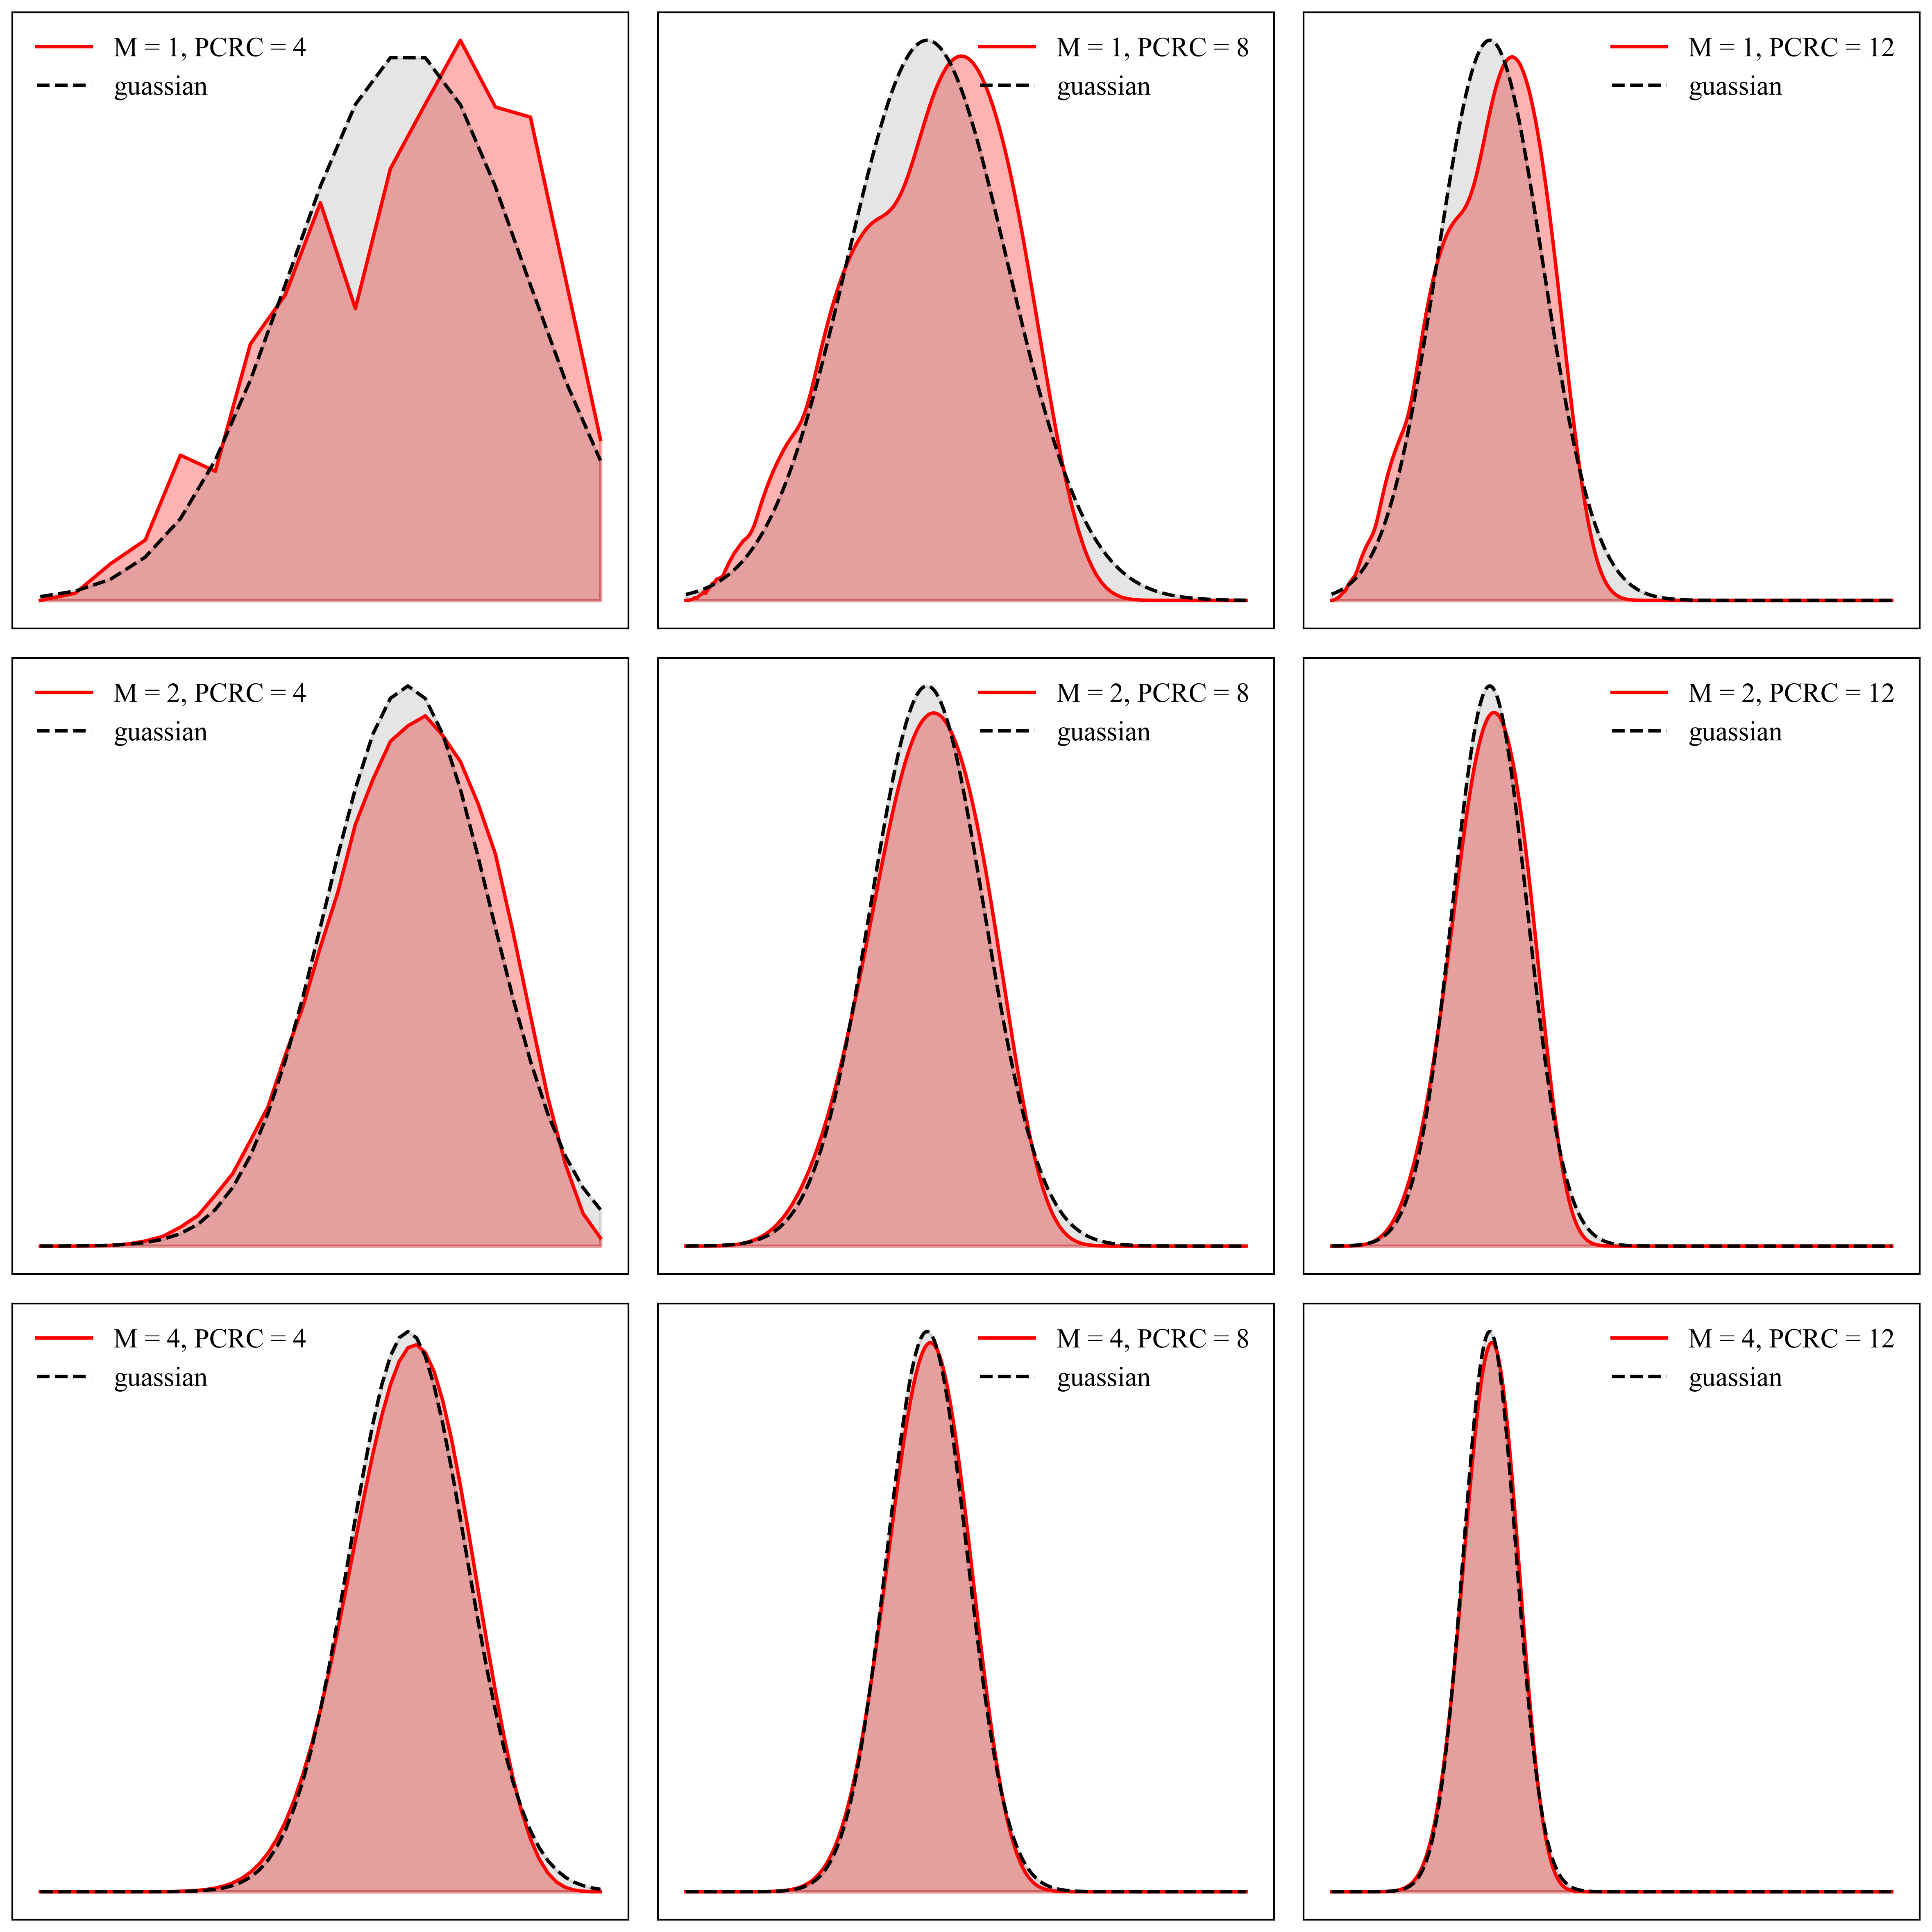

In [210]:
fig = plt.figure(figsize = (8,8))
iters = [4,8,12]
for i,it in enumerate(iters):
    pmf = Ps[it]
    N = pmf.size
    X = np.arange(N)
    u = np.sum(X * pmf)
    sigma = np.sqrt(np.sum((X-u)**2 * pmf))
    NY = 1/(np.sqrt(2*pi)*sigma) * np.exp(-(X-u)**2/(2*sigma**2))
    ax = plt.subplot(3,3,i+1)
    plt.plot(pmf,c = 'r',label = 'M = 1, PCRC = ' + str(it))
    plt.plot(NY,c = 'black',label = 'guassian')
    plt.fill_between(X,0,pmf,color = 'red', alpha = 0.3)
    plt.fill_between(X,0,NY,color = 'black', alpha = 0.1)
    
    plt.legend()
    ax.get_yaxis().set_visible(False)
    ax.get_xaxis().set_visible(False)
#     plt.title(f'{round(it,4)} iter, u={round(u,3)}, sigma = {round(sigma,3)}')
    
    pmf = convolve(pmf,pmf)
    N = pmf.size
    X = np.arange(N)
    sigma = sigma * sqrt(2)
    u = u * 2
    NY = 1/(np.sqrt(2*pi)*sigma) * np.exp(-(X-u)**2/(2*sigma**2))
    ax = plt.subplot(3,3,i+4)
    plt.plot(pmf,c = 'r',label = 'M = 2, PCRC = ' + str(it))
    plt.plot(NY,c = 'black',label = 'guassian')
    plt.fill_between(X,0,pmf,color = 'red', alpha = 0.3)
    plt.fill_between(X,0,NY,color = 'black', alpha = 0.1)
    plt.legend()
#     plt.title(f'{round(it,4)} iter, u={round(u,3)}, sigma = {round(sigma,3)}')
    ax.get_yaxis().set_visible(False)
    ax.get_xaxis().set_visible(False)
    
    
    pmf = convolve(pmf,pmf)
    N = pmf.size
    X = np.arange(N)
    sigma = sigma * sqrt(2)
    u = u * 2
    NY = 1/(np.sqrt(2*pi)*sigma) * np.exp(-(X-u)**2/(2*sigma**2))
    ax = plt.subplot(3,3,i+7)
    plt.plot(pmf,c = 'r',label = 'M = 4, PCRC = ' + str(it))
    plt.plot(NY,c = 'black',label = 'guassian')
    plt.fill_between(X,0,pmf,color = 'red', alpha = 0.3)
    plt.fill_between(X,0,NY,color = 'black', alpha = 0.1)
    plt.legend()
    ax.get_yaxis().set_visible(False)
    ax.get_xaxis().set_visible(False)
#     plt.title(f'{round(it,4)} iter, u={round(u,3)}, sigma = {round(sigma,3)}')
plt.tight_layout()
plt.show()

# Sampling

* the signal-to-noise ratio can be improved by repeating the observation process. 
* Although the mean of base composition remains the same for different sampling depths, the variance will increase with low sampling depth, and it will be more likely that a wrong base is observed more frequently than the actual base, which leads to a voting error!

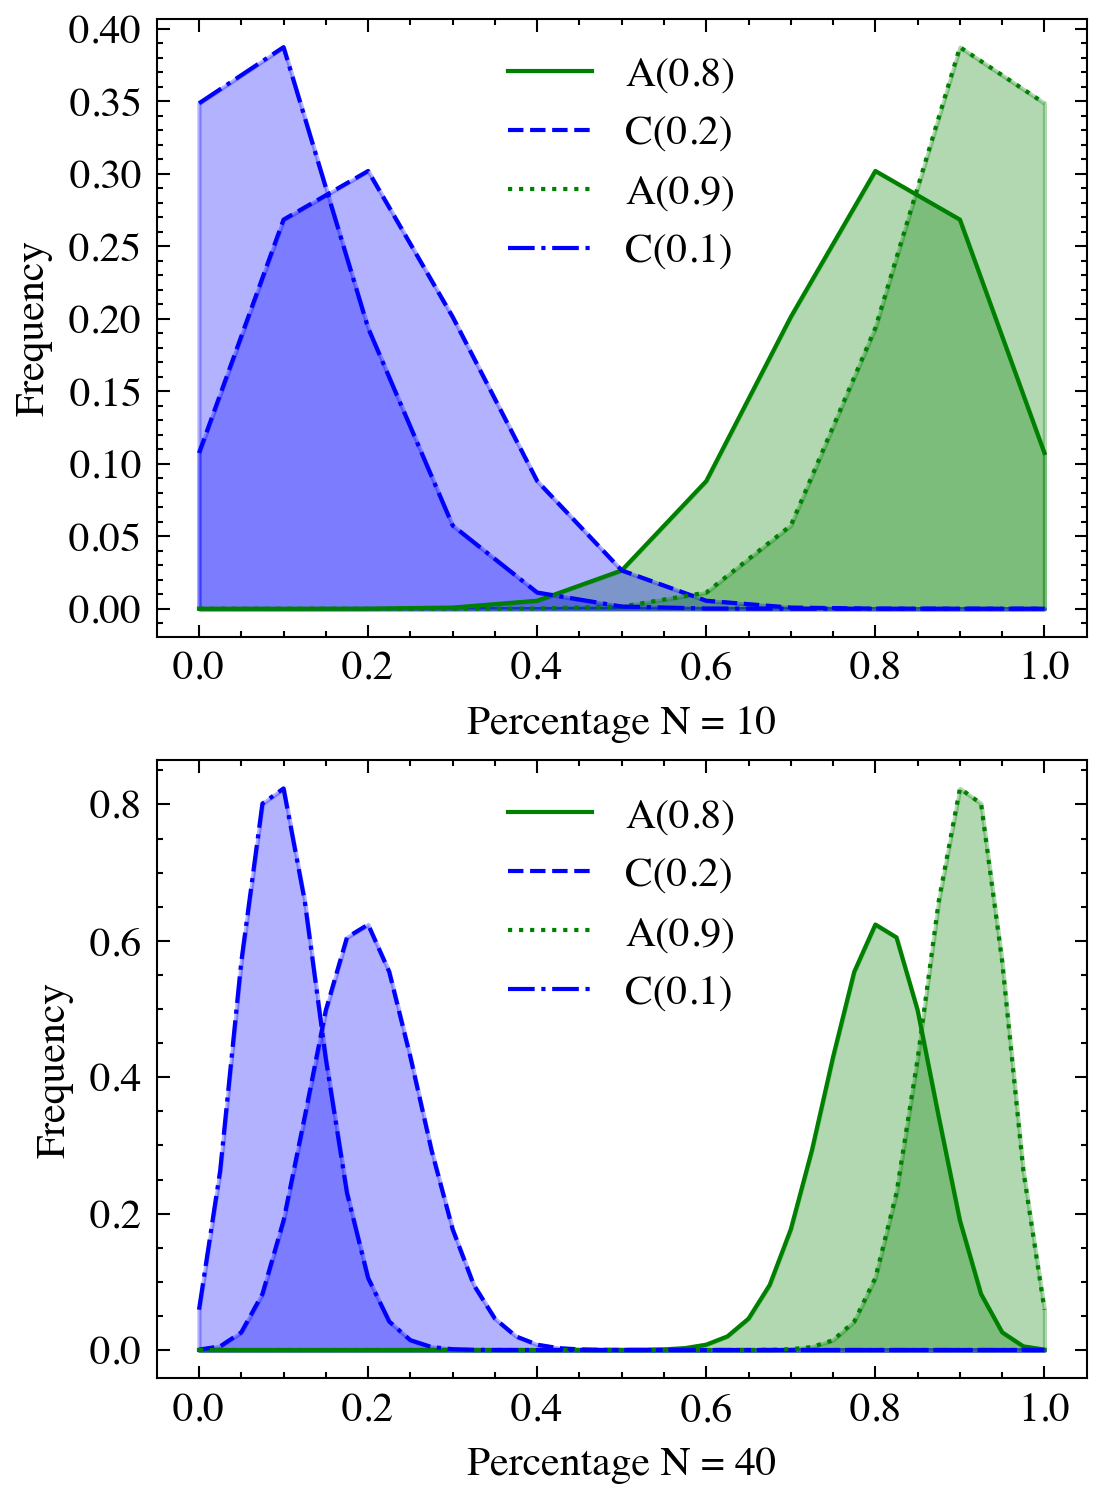

In [23]:
pA = 0.8
pC = 0.2

n1 = 10
n2 = 40
X = np.arange(0,n2+1)

def plotDist(X,Prob,label,color):
    plt.fill_between(X,0,Prob,color = color,alpha = 0.3)
    plt.plot(X,Prob,label = label,color = color)

ProbA1 = binom.pmf(X,n1,pA)
ProbC1 = binom.pmf(X,n1,pC)
ProbA3 = binom.pmf(X,n1,0.9)
ProbC3 = binom.pmf(X,n1,0.1)

ProbA2 = binom.pmf(X,n2,pA) * n2/n1
ProbC2 = binom.pmf(X,n2,pC) * n2/n1 
ProbA4 = binom.pmf(X,n2,0.9) * n2/n1
ProbC4 = binom.pmf(X,n2,0.1) * n2/n1

X1 = X / n1
X2 = X / n2
fig = plt.figure(figsize = (4,6),dpi = 300)

plt.subplot(2,1,1)
plotDist(X1[:n1+1],ProbA1[:n1+1],'A(0.8)','green')
plotDist(X1[:n1+1],ProbC1[:n1+1],'C(0.2)','blue')
plotDist(X1[:n1+1],ProbA3[:n1+1],'A(0.9)','green')
plotDist(X1[:n1+1],ProbC3[:n1+1],'C(0.1)','blue')

plt.xticks(fontsize=fontSize)
plt.yticks(fontsize=fontSize)
plt.legend(fontsize=fontSize)
plt.xlabel('Percentage N = 10',fontsize=fontSize)
plt.ylabel('Frequency',fontsize=fontSize)

plt.subplot(2,1,2)
plotDist(X2,ProbA2,'A(0.8)','green')
plotDist(X2,ProbC2,'C(0.2)','blue')
plotDist(X2,ProbA4,'A(0.9)','green')
plotDist(X2,ProbC4,'C(0.1)','blue')

plt.xticks(fontsize=fontSize)
plt.yticks(fontsize=fontSize)
plt.legend(fontsize=fontSize)
plt.xlabel('Percentage N = 40',fontsize=fontSize)
plt.ylabel('Frequency',fontsize=fontSize)

fig.savefig('dist.png', dpi=300)

# Sequencing

<img src="https://tva1.sinaimg.cn/large/007S8ZIlly1gi42g9kuydj30sg0foakj.jpg" style="zoom:30%;" />

* **NGS sequencing:**: oligos are immobilized to a solid surface and amplified to form clusters in order to improve signal strength, then dye-labelled modified nucleotides are added to each cluster one base at a time according to the template, so that the template base can be determined via imaging. 
* **Nanopore Sequencing**: base are determined with current drop it generates when passing through a nanoscale pole.

## Substitution error

* **Substitutions** are the most common error type when sequencing, which happens because of **insufficient discrimination of the emitted signal of respective base**
* For example, current drop of different bases overlaps when using nanopore sequencing:

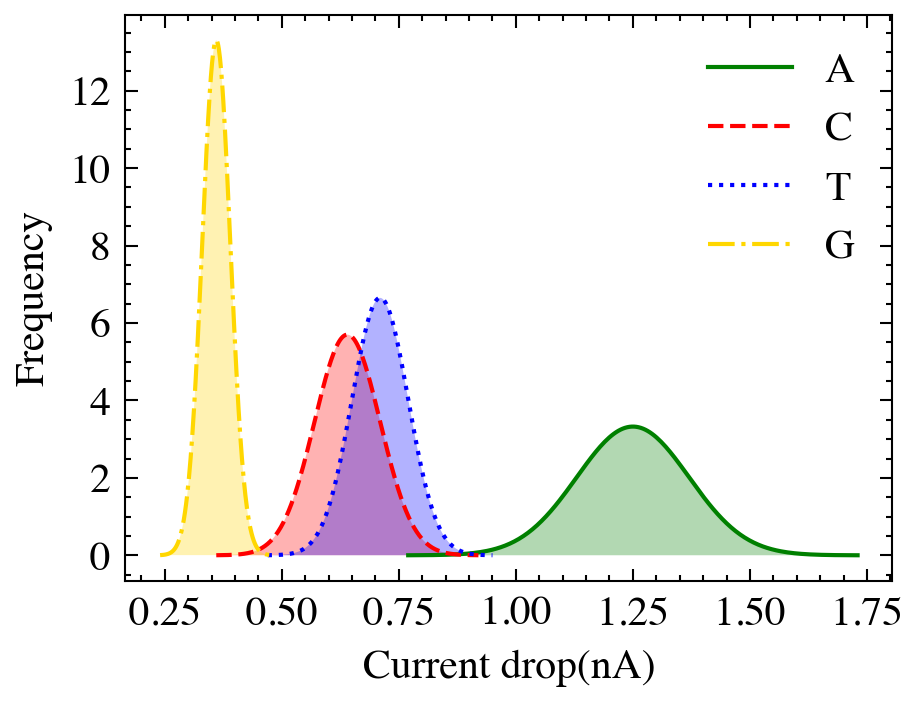

In [22]:
uA, sigmaA = 1.25, 0.12
uC, sigmaC = 0.64, 0.07
uT, sigmaT = 0.71, 0.06 
uG, sigmaG = 0.36, 0.03

def plot_Normal(X,u,sigma,label,color = 'red'):
    X = np.linspace(u-4*sigma,u+4*sigma,200)
    Prob = 1/(np.sqrt(2*pi)*sigma) * np.exp(-(X-u)**2/(2*sigma**2))
    plt.fill(X,Prob , color , alpha=0.3)
    plt.plot(X,Prob,label = label,color = color)
    
fig = plt.figure(dpi=300)
X = np.linspace(0,1.6,200)
plot_Normal(X,uA,sigmaA,'A','green')
plot_Normal(X,uC,sigmaC,'C','red')
plot_Normal(X,uT,sigmaT,'T','blue')
plot_Normal(X,uG,sigmaG,'G','gold')


plt.xticks(fontsize=fontSize)
plt.yticks(fontsize=fontSize)
plt.legend(fontsize=fontSize)
plt.xlabel('Current drop(nA)',fontsize=fontSize)
plt.ylabel('Frequency',fontsize=fontSize)
fig.savefig('Seq distribution.png', dpi=300)    